In [1]:
pip install pandas numpy matplotlib scikit-learn yfinance

Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Data Collection

In [3]:
stock_data = yf.download('^GSPC', start='2010-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


Data Pre-Processing

In [4]:
# Calculate daily returns
stock_data['Return'] = stock_data['Adj Close'].pct_change()

# Calculate moving averages and volatility as features
stock_data['MA_50'] = stock_data['Adj Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Adj Close'].rolling(window=200).mean()
stock_data['Volatility'] = stock_data['Return'].rolling(window=50).std()

# Drop NaN values created by rolling calculations
stock_data.dropna(inplace=True)

# Selecting relevant features for clustering
features = stock_data[['Return', 'MA_50', 'MA_200', 'Volatility']]

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Clustering with K-Means

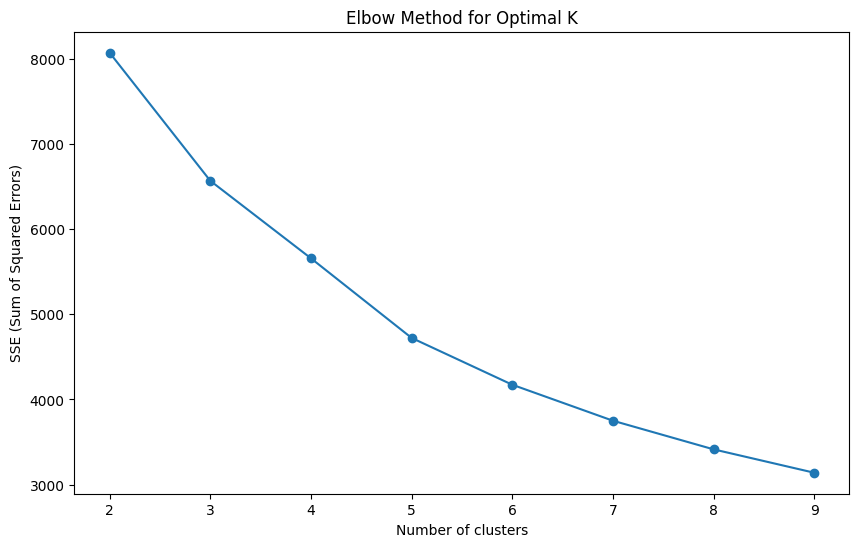

In [5]:
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.show()

Applying K-Means and Analysing Clusters

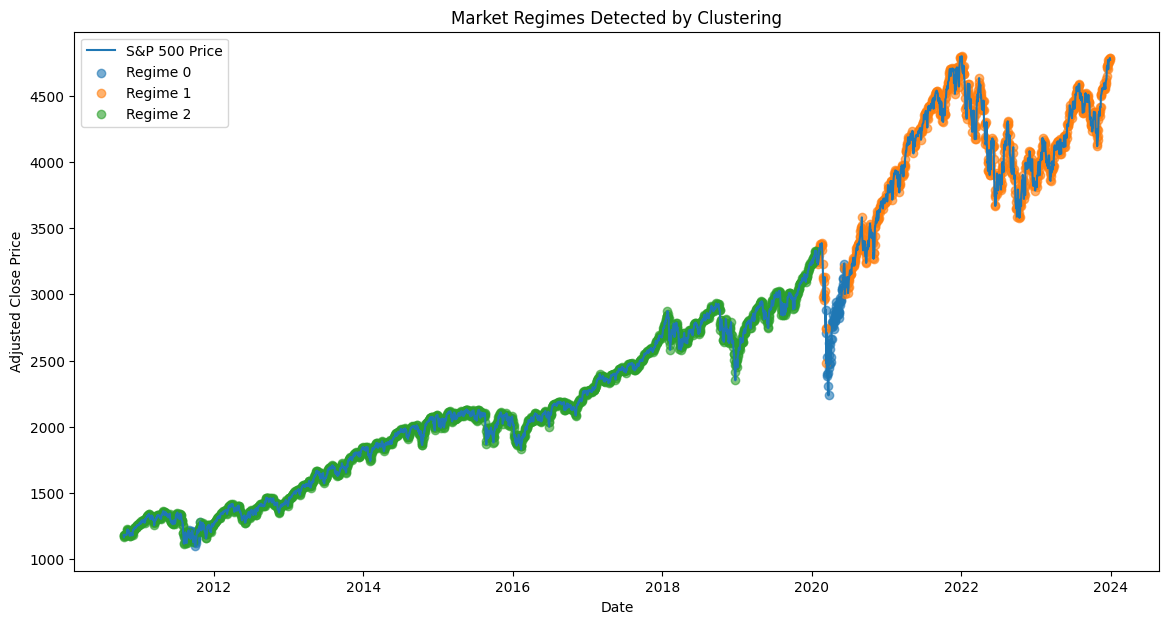

In [6]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
stock_data['Regime'] = kmeans.fit_predict(features_scaled)

# Visualizing the regimes
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label='S&P 500 Price')
for i in range(optimal_k):
    plt.scatter(stock_data[stock_data['Regime'] == i].index,
                stock_data[stock_data['Regime'] == i]['Adj Close'], label=f'Regime {i}', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Market Regimes Detected by Clustering')
plt.legend()
plt.show()

Analysing and Labelling Clusters

In [7]:
# Calculate average returns and volatility for each regime
for i in range(optimal_k):
    regime_data = stock_data[stock_data['Regime'] == i]
    avg_return = regime_data['Return'].mean()
    avg_volatility = regime_data['Volatility'].mean()
    print(f'Regime {i}: Avg Return = {avg_return:.4f}, Avg Volatility = {avg_volatility:.4f}')

# Manually label the regimes based on characteristics (e.g., high return, low volatility = Bull Market)
regime_labels = {0: 'Bull', 1: 'Bear', 2: 'Neutral'}  # Example labels; adjust based on analysis
stock_data['Regime_Label'] = stock_data['Regime'].map(regime_labels)

Regime 0: Avg Return = 0.0077, Avg Volatility = 0.0318
Regime 1: Avg Return = 0.0001, Avg Volatility = 0.0108
Regime 2: Avg Return = 0.0003, Avg Volatility = 0.0081


Model Validation

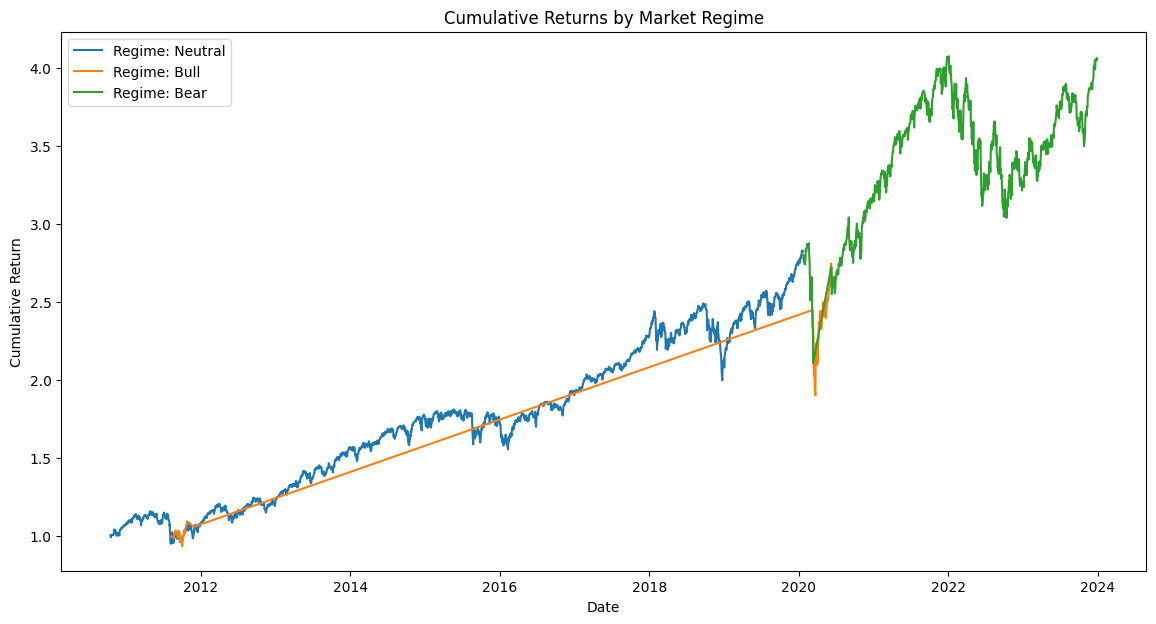

In [8]:
# Calculate cumulative returns for each regime
stock_data['Cumulative_Return'] = (1 + stock_data['Return']).cumprod()

# Plot cumulative returns per regime
plt.figure(figsize=(14, 7))
for label in stock_data['Regime_Label'].unique():
    regime_returns = stock_data[stock_data['Regime_Label'] == label]['Cumulative_Return']
    plt.plot(regime_returns, label=f'Regime: {label}')

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns by Market Regime')
plt.legend()
plt.show()

Predicting Market Regimes

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare the dataset for supervised learning
X = features_scaled
y = stock_data['Regime']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        38
           1       0.99      1.00      0.99       273
           2       1.00      1.00      1.00       686

    accuracy                           0.99       997
   macro avg       1.00      0.96      0.98       997
weighted avg       1.00      0.99      0.99       997

